In [1]:
import xarray as xr
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
flds = xr.open_dataset("../data/all-fields.nc")

In [3]:
flds

<xarray.Dataset>
Dimensions:    (t: 4000, x: 32)
Coordinates:
  * t          (t) float64 0.0 0.5 1.0 1.5 ... 1.998e+03 1.999e+03 2e+03
  * x          (x) float64 0.2641 0.7924 1.321 1.849 ... 15.05 15.58 16.11 16.64
Data variables:
    force-(x)  (t, x) float64 ...

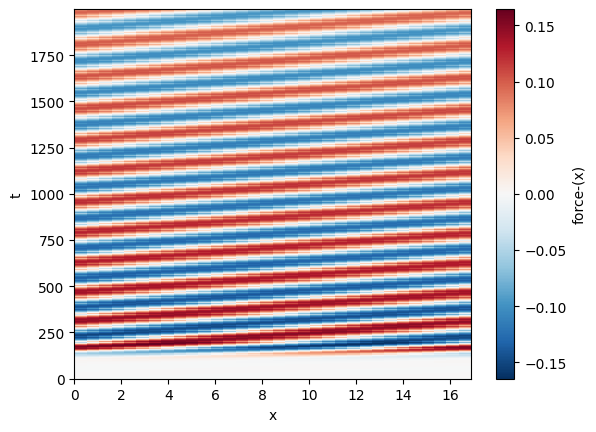

In [7]:
flds["force-(x)"].plot()

In [4]:
xax = flds.coords["x"].data
tax = flds.coords["t"].data

dx = xax[1]-xax[0]
xmax = xax[-1] + dx/2.
dt = tax[1]-tax[0]

In [17]:
"""
Interpolates the E field on a periodic domain at the given points `xs`.
The E field parameter contains values of E at Fourier collocation points.
"""
def interpolate_electric_field(E, xs):
    L = flds.x.data[-1] + dx/2
    E_modes = jnp.fft.fft(E.data)
    N = len(E)
    mode_numbers = jnp.fft.fftfreq(len(E)) * N
    # Form the trigonometric Vandermonde matrix.
    # Its rows correspond to Fourier modes, and its columns to the points xs.
    # Need to shift `xs` to the domain starting at x=0, because that's what the
    # FFT assumed about the E array.
    A = jnp.exp(2*jnp.pi*1j * (xs - dx/2) / L * jnp.reshape(mode_numbers, (N, 1))) / N
    
    return jnp.real(A.T @ E_modes)


"""
Accepts an array of particle positions at time t^n, and corresponding particle velocities
at time t^{n-1/2}.
"""
def leapfrog_push(xs, vs, n, dt):
    E = flds["force-(x)"][n].data
    # Fs = interpolate_electric_field(E, xs)
    Fs = np.interp(xs, flds["force-(x)"].x.data, E, period=xmax)
    vs_next = vs + Fs * dt
    xs_next = xs + vs_next * dt
    # Clamp the positions to the spatial domain
    dx = flds.x.data[0] * 2
    L = float(flds.x.data[-1] + dx/2)
    xs_next = jnp.mod(xs_next, jnp.array([L]))

    xp = xs_next
    # xp = np.where(xp > xmax, xp - xmax, np.where(xp < 0, xp + xmax, xp))
    
    return xp, vs_next


"""
Performs the single half timestep push necessary to kick off the Leapfrog method.
"""
def leapfrog_start(x0s, v0s, dt):
    E = flds["force-(x)"][0].data
    #fs = interpolate_electric_field(E, x0s)
    Fs = np.interp(x0s, flds["force-(x)"].x.data, E, period=xmax)
    vs_next = v0s + Fs*dt/2
    return x0s, vs_next


def leapfrog_runner(x0s, v0s, dt):
    xs, vs = leapfrog_start(x0s, v0s, dt)
    x_history = jnp.empty((0, len(x0s)))
    v_history = jnp.empty((0, len(x0s)))
    # for n in jnp.arange(len(flds["force-(x)"])):
    for n in range(2000):
        xs, vs = leapfrog_push(xs, vs, n, dt)
        x_history = jnp.vstack((x_history, xs))
        v_history = jnp.vstack((v_history, vs))

    return x_history, v_history


xs, vs = leapfrog_runner(jnp.zeros(3), jnp.array([0.0, 2.4, 4.1]), dt)

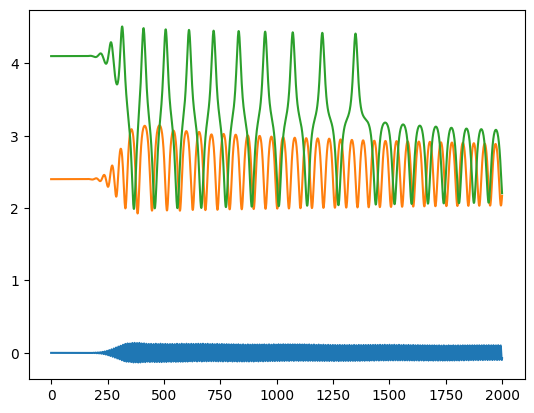

In [18]:
fig = plt.figure()
for i in range(3):
    plt.plot(np.arange(vs.shape[0]), vs[:, i])

In [15]:
vs.shape

(400, 10)